In [1]:
import matplotlib
import pandas as pd
import numpy as np
import csv
import re
%matplotlib inline 
import matplotlib.pyplot as plt

## Predictions of transmembrane helix domain with TMHMM2.0

Fasta file for the full human genome was runned on:
http://www.cbs.dtu.dk/services/TMHMM-2.0/

User guide:
http://www.cbs.dtu.dk/services/TMHMM-2.0/TMHMM2.0.guide.html#output

### Columns descriptions:
- "len=": the length of the protein sequence.
- "ExpAA=": The expected number of amino acids intransmembrane helices (see above).
- "First60=": The expected number of amino acids in transmembrane helices in the first 60 amino acids of the protein (see above).
- "PredHel=": The number of predicted transmembrane helices by N-best.
- "Topology=": The topology predicted by N-best.

The topology is given as the position of the transmembrane helices separated by 'i' if the loop is on the inside or 'o' if it is on the outside. The above example 'i7-29o44-66i87-109o' means that it starts on the inside, has a predicted TMH at position 7 to 29, the outside, then a TMH at position 44-66 etc.

In [146]:
# Loading transmembrane helix domain data
TMD = pd.read_table('data/TMHMM_result.txt', delim_whitespace=True, header=None)
TMD = TMD.rename(columns={0: 'ID', 1:'len', 2: 'ExpAA', 
                       3: 'First60', 4: 'PredHel', 5: 'Topology'})
TMD.head()

,ID,len,ExpAA,First60,PredHel,Topology
0,sp|Q96IY4|CBPB2_HUMAN,len=423,ExpAA=2.22,First60=1.15,PredHel=0,Topology=o
1,sp|P22362|CCL1_HUMAN,len=96,ExpAA=0.07,First60=0.07,PredHel=0,Topology=o
2,sp|Q8NCR9|CLRN3_HUMAN,len=226,ExpAA=90.50,First60=22.95,PredHel=4,Topology=i13-35o94-116i129-151o179-201i
3,sp|Q8IUK8|CBLN2_HUMAN,len=224,ExpAA=9.17,First60=8.91,PredHel=0,Topology=o
4,sp|Q9BX69|CARD6_HUMAN,len=1037,ExpAA=0.00,First60=0.00,PredHel=0,Topology=o


In [147]:
TMD.shape

(20364, 6)

In [148]:
TMD['len'] = TMD['len'].map(lambda x: x.replace('len=', ''))
TMD['ExpAA'] = TMD['ExpAA'].map(lambda x: x.replace('ExpAA=', ''))
TMD['First60'] = TMD['First60'].map(lambda x: x.replace('First60=', ''))
TMD['PredHel'] = TMD['PredHel'].map(lambda x: x.replace('PredHel=', ''))
TMD['Topology'] = TMD['Topology'].map(lambda x: x.replace('Topology=', ''))
TMD['Topology'] = TMD['Topology'].map(lambda x: re.findall('\d{1,}-\d{1,}', x))
TMD['ID'] = TMD['ID'].map(lambda x: x.split('|')[1])
TMD.head()

,ID,len,ExpAA,First60,PredHel,Topology
0,Q96IY4,423,2.22,1.15,0,[]
1,P22362,96,0.07,0.07,0,[]
2,Q8NCR9,226,90.50,22.95,4,"[13-35, 94-116, 129-151, 179-201]"
3,Q8IUK8,224,9.17,8.91,0,[]
4,Q9BX69,1037,0.00,0.00,0,[]


In [149]:
l_topo = TMD['Topology'].values
l_len = TMD['len'].values.astype(int)

In [150]:
l_seq =[]
for i in range(len(l_len)):
    seq = [0]* l_len[i]
    if l_topo[i] != []:
        for x in l_topo[i]:
            interval = re.findall('\d{1,}', x)
            seq[int(interval[0]):int(interval[1])+1] = [1 for n in seq[int(interval[0]):int(interval[1])+1]]
    l_seq.append(seq)
    

In [151]:
TMD['Topology Seq'] = l_seq
TMD.head()

,ID,len,ExpAA,First60,PredHel,Topology,Topology Seq
0,Q96IY4,423,2.22,1.15,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,P22362,96,0.07,0.07,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Q8NCR9,226,90.50,22.95,4,"[13-35, 94-116, 129-151, 179-201]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
3,Q8IUK8,224,9.17,8.91,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Q9BX69,1037,0.00,0.00,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## SignalIP5 Prediction

site: https://services.healthtech.dtu.dk/service.php?SignalP-5.0

papers: 
- https://www.nature.com/articles/s41587-019-0036-z
- https://academic.oup.com/peds/article/10/11/1241/1506251


Signal peptide and cleavage sites in gram+, gram- and eukaryotic amino acid sequences
The SignalP 5.0 server predicts the presence of signal peptides and the location of their cleavage sites in proteins from Archaea, Gram-positive Bacteria, Gram-negative Bacteria and Eukarya. In Bacteria and Archaea, SignalP 5.0 can discriminate between three types of signal peptides:

- Sec/SPI: "standard" secretory signal peptides transported by the Sec translocon and cleaved by Signal Peptidase I (Lep)
- Sec/SPII: lipoprotein signal peptides transported by the Sec translocon and cleaved by Signal Peptidase II (Lsp)
- Tat/SPI: Tat signal peptides transported by the Tat translocon and cleaved by Signal Peptidase I (Lep)

In [211]:
SP = pd.read_table('data/signalIP5_preds.txt')
SP.head()

,ID,Prediction,SP(Sec/SPI),OTHER,CS Position
0,sp_Q96IY4_CBPB2_HUMAN,SP(Sec/SPI),0.956504,0.043496,CS pos: 22-23. VFA-FQ. Pr: 0.8438
1,sp_P22362_CCL1_HUMAN,SP(Sec/SPI),0.998593,0.001407,CS pos: 23-24. VDS-KS. Pr: 0.8532
2,sp_Q8NCR9_CLRN3_HUMAN,OTHER,0.161518,0.838482,NaN
3,sp_Q8IUK8_CBLN2_HUMAN,SP(Sec/SPI),0.909754,0.090246,CS pos: 51-52. VRA-QN. Pr: 0.8563
4,sp_Q9BX69_CARD6_HUMAN,OTHER,0.000208,0.999792,NaN


In [212]:
SP['CS Position'] = SP['CS Position'].astype(str).map(lambda x: re.findall('\d{1,}-\d{1,}', x))
SP['ID'] = SP['ID'].map(lambda x: x.split('_')[1])
SP.head()

,ID,Prediction,SP(Sec/SPI),OTHER,CS Position
0,Q96IY4,SP(Sec/SPI),0.956504,0.043496,[22-23]
1,P22362,SP(Sec/SPI),0.998593,0.001407,[23-24]
2,Q8NCR9,OTHER,0.161518,0.838482,[]
3,Q8IUK8,SP(Sec/SPI),0.909754,0.090246,[51-52]
4,Q9BX69,OTHER,0.000208,0.999792,[]


## Merge the SignalIP5, TMHMM2 and MS tables

Only the columns we want... 
What do we want???

In [216]:
Combined_prep = pd.merge(TMD, SP, on="ID")
Combined_prep.head()

,ID,len,ExpAA,First60,PredHel,Topology,Topology Seq,Prediction,SP(Sec/SPI),OTHER,CS Position
0,Q96IY4,423,2.22,1.15,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SP(Sec/SPI),0.956504,0.043496,[22-23]
1,P22362,96,0.07,0.07,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SP(Sec/SPI),0.998593,0.001407,[23-24]
2,Q8NCR9,226,90.50,22.95,4,"[13-35, 94-116, 129-151, 179-201]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",OTHER,0.161518,0.838482,[]
3,Q8IUK8,224,9.17,8.91,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SP(Sec/SPI),0.909754,0.090246,[51-52]
4,Q9BX69,1037,0.00,0.00,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OTHER,0.000208,0.999792,[]


In [217]:
l_cs = Combined_prep['CS Position'].values
l_len = Combined_prep['len'].values.astype(int)
l_seq =[]
for i in range(len(l_len)):
    seq = [0]* l_len[i]
    if l_cs[i] != []:
        for x in l_cs[i]:
            interval = re.findall('\d{1,}', x)
            seq[0:int(interval[1])+1] = [1 for n in seq[0:int(interval[1])+1]]
    l_seq.append(seq)
    
Combined_prep['Signal Peptide Seq'] = l_seq

In [218]:
Combined_prep.head()

,ID,len,ExpAA,First60,PredHel,Topology,Topology Seq,Prediction,SP(Sec/SPI),OTHER,CS Position,Signal Peptide Seq
0,Q96IY4,423,2.22,1.15,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SP(Sec/SPI),0.956504,0.043496,[22-23],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,P22362,96,0.07,0.07,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SP(Sec/SPI),0.998593,0.001407,[23-24],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,Q8NCR9,226,90.50,22.95,4,"[13-35, 94-116, 129-151, 179-201]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",OTHER,0.161518,0.838482,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Q8IUK8,224,9.17,8.91,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SP(Sec/SPI),0.909754,0.090246,[51-52],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,Q9BX69,1037,0.00,0.00,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OTHER,0.000208,0.999792,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [219]:
Combined_prep.shape

(20364, 12)

## Loading MS compartment Prediction dataset 

In [220]:
df = pd.read_csv('data/Dataset_onlyPredict.csv', sep="\t")
df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence
0,Q9BZC7,Endosome,Very High,MGFLHQLQLLLWKNVTLKRRSPWVLAFEIFIPLVLFFILLGLRQKK...
1,Q6RW13,Endosome,Very High,MELPAVNLKVILLGHWLLTTWGCIVFSGSYAWANFTILALGVWAVA...
2,Q9P2R3,Endosome,Very High,MAEEEVAKLEKHLMLLRQEYVKLQKKLAETEKRCALLAAQANKESS...
3,Q96NW4,Endosome,Very High,MALYDEDLLKNPFYLALQKCRPDLCSKVAQIHGIVLVPCKGSLSSS...
4,O00203,Endosome,Very High,MSSNSFPYNEQSGGGEATELGQEATSTISPSGAFGLFSSDLKKNED...


In [221]:
df.shape

(5162, 4)

In [222]:
lengh_seq = []
for seq in df["Sequence"]:
    lengh_seq.append(len(seq))
lengh_seq = np.asarray(lengh_seq)

In [223]:
df["Sequence Lengh"] = lengh_seq

In [224]:
df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh
0,Q9BZC7,Endosome,Very High,MGFLHQLQLLLWKNVTLKRRSPWVLAFEIFIPLVLFFILLGLRQKK...,2435
1,Q6RW13,Endosome,Very High,MELPAVNLKVILLGHWLLTTWGCIVFSGSYAWANFTILALGVWAVA...,159
2,Q9P2R3,Endosome,Very High,MAEEEVAKLEKHLMLLRQEYVKLQKKLAETEKRCALLAAQANKESS...,1169
3,Q96NW4,Endosome,Very High,MALYDEDLLKNPFYLALQKCRPDLCSKVAQIHGIVLVPCKGSLSSS...,1050
4,O00203,Endosome,Very High,MSSNSFPYNEQSGGGEATELGQEATSTISPSGAFGLFSSDLKKNED...,1094


# Merge That dataset to the other other predictions

In [225]:
Full_df = pd.merge(df, Combined_prep, how='inner', left_on= 'Lead Protein ID', right_on= 'ID',
         left_index=False, right_index=False, sort=False)

In [226]:
Full_df.drop('ID', axis=1, inplace=True)
Full_df.drop('len', axis=1, inplace=True)
Full_df.drop('OTHER', axis=1, inplace=True)

In [227]:
Full_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh,ExpAA,First60,PredHel,Topology,Topology Seq,Prediction,SP(Sec/SPI),CS Position,Signal Peptide Seq
0,Q9BZC7,Endosome,Very High,MGFLHQLQLLLWKNVTLKRRSPWVLAFEIFIPLVLFFILLGLRQKK...,2435,289.13,24.19,12,"[21-40, 705-727, 748-770, 785-807, 812-834, 84...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OTHER,0.002506,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Q6RW13,Endosome,Very High,MELPAVNLKVILLGHWLLTTWGCIVFSGSYAWANFTILALGVWAVA...,159,69.11,32.19,3,"[24-46, 53-75, 85-107]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OTHER,0.011464,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Q9P2R3,Endosome,Very High,MAEEEVAKLEKHLMLLRQEYVKLQKKLAETEKRCALLAAQANKESS...,1169,0.01,0.00,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OTHER,0.000188,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Q96NW4,Endosome,Very High,MALYDEDLLKNPFYLALQKCRPDLCSKVAQIHGIVLVPCKGSLSSS...,1050,0.09,0.00,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OTHER,0.001217,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,O00203,Endosome,Very High,MSSNSFPYNEQSGGGEATELGQEATSTISPSGAFGLFSSDLKKNED...,1094,0.27,0.00,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OTHER,0.000804,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


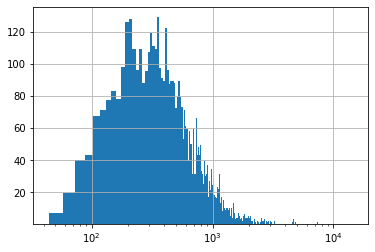

In [228]:
fig, ax = plt.subplots()
Full_df['Sequence Lengh'].hist(ax=ax, bins=1000, bottom=0.1)
ax.set_xscale('log')

In [175]:
indexNames = Full_df[ Full_df['Sequence Lengh'] > 1500 ].index
 
# Delete these row indexes from dataFrame
Full_df = Full_df.drop(indexNames , inplace=False).reset_index(drop=True)
Full_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh,ExpAA,First60,PredHel,Topology,Topology Seq,Prediction,SP(Sec/SPI),CS Position,CS position Seq
0,Q6RW13,Endosome,Very High,MELPAVNLKVILLGHWLLTTWGCIVFSGSYAWANFTILALGVWAVA...,159,69.11,32.19,3,"[24-46, 53-75, 85-107]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OTHER,0.011464,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Q9P2R3,Endosome,Very High,MAEEEVAKLEKHLMLLRQEYVKLQKKLAETEKRCALLAAQANKESS...,1169,0.01,0.00,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OTHER,0.000188,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Q96NW4,Endosome,Very High,MALYDEDLLKNPFYLALQKCRPDLCSKVAQIHGIVLVPCKGSLSSS...,1050,0.09,0.00,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OTHER,0.001217,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,O00203,Endosome,Very High,MSSNSFPYNEQSGGGEATELGQEATSTISPSGAFGLFSSDLKKNED...,1094,0.27,0.00,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OTHER,0.000804,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,O14617,Endosome,Very High,MALKMVKGSIDRMFDKNLQDLVRGIRNHKEDEAKYISQCIDEIKQE...,1153,0.63,0.02,0,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OTHER,0.000874,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [229]:
Full_df.shape

(5154, 14)

In [230]:
Full_df["Compartment Prediction"].value_counts() / len(Full_df) *100

Large Protein Complex     50.679084
Mitochondrion             12.747381
ER                        10.263873
Plasma membrane            9.798215
Endosome                   5.898331
Golgi                      3.686457
Actin binding proteins     1.920838
Lysosome                   1.707412
Ergic/cisGolgi             1.416376
ER_high_curvature          0.873108
Nuclear pore complex       0.523865
Peroxisome                 0.485060
Name: Compartment Prediction, dtype: float64

## Symplify dataset categories
Remove too small and merge what could be merged.

In [231]:
df_simple = Full_df.replace('ER_high_curvature', 'ER')
df_simple = df_simple[df_simple["Compartment Prediction"] != 'Nuclear pore complex'].reset_index(drop=True)
df_simple = df_simple[df_simple["Compartment Prediction"] != 'Peroxisome'].reset_index(drop=True)
df_simple = df_simple[df_simple["Compartment Prediction"] != 'Ergic/cisGolgi'].reset_index(drop=True)

# Remove actin because not a compartment, cannot be compared to other algorithm.
df_simple = df_simple[df_simple["Compartment Prediction"] != 'Actin binding proteins'].reset_index(drop=True)

In [232]:
df_simple["Compartment Prediction"].value_counts() / len(df_simple) *100

Large Protein Complex    52.981744
Mitochondrion            13.326572
ER                       11.643002
Plasma membrane          10.243408
Endosome                  6.166329
Golgi                     3.853955
Lysosome                  1.784990
Name: Compartment Prediction, dtype: float64

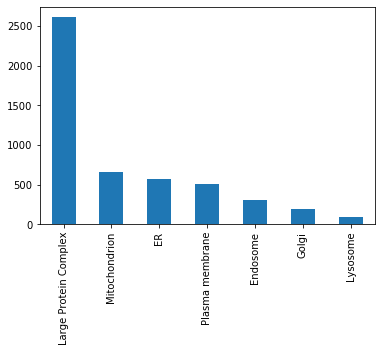

In [233]:
df_simple['Compartment Prediction'].value_counts().plot.bar()

In [234]:
df_simple.groupby(["Compartment Prediction", "Prediction"]).count()

Lead Protein ID  Prediction Confidence  \
Compartment Prediction Prediction                                            
ER                     OTHER                    377                    377   
                       SP(Sec/SPI)              197                    197   
Endosome               OTHER                    270                    270   
                       SP(Sec/SPI)               34                     34   
Golgi                  OTHER                    172                    172   
                       SP(Sec/SPI)               18                     18   
Large Protein Complex  OTHER                   2603                   2603   
                       SP(Sec/SPI)                9                      9   
Lysosome               OTHER                     36                     36   
                       SP(Sec/SPI)               52                     52   
Mitochondrion          OTHER                    649                    649   
                       SP(Sec/SPI)                8                      8   
Plasma membrane        OTHER                    358                    358   
                       SP(Sec/SPI)              147                    147   

                                    Sequence  Sequence Lengh  ExpAA  First60  \
Compartment Prediction Prediction                                              
ER                     OTHER             377             377    377      377   
                       SP(Sec/SPI)       197             197    197      197   
Endosome               OTHER             270             270    270      270   
                       SP(Sec/SPI)        34              34     34       34   
Golgi                  OTHER             172             172    172      172   
                       SP(Sec/SPI)        18              18     18       18   
Large Protein Complex  OTHER            2603            2603   2603     2603   
                       SP(Sec/SPI)         9               9      9        9   
Lysosome               OTHER              36              36     36       36   
                       SP(Sec/SPI)        52              52     52       52   
Mitochondrion          OTHER             649             649    649      649   
                       SP(Sec/SPI)         8               8      8        8   
Plasma membrane        OTHER             358             358    358      358   
                       SP(Sec/SPI)       147             147    147      147   

                                    PredHel  Topology  Topology Seq  \
Compartment Prediction Prediction                                     
ER                     OTHER            377       377           377   
                       SP(Sec/SPI)      197       197           197   
Endosome               OTHER            270       270           270   
                       SP(Sec/SPI)       34        34            34   
Golgi                  OTHER            172       172           172   
                       SP(Sec/SPI)       18        18            18   
Large Protein Complex  OTHER           2603      2603          2603   
                       SP(Sec/SPI)        9         9             9   
Lysosome               OTHER             36        36            36   
                       SP(Sec/SPI)       52        52            52   
Mitochondrion          OTHER            649       649           649   
                       SP(Sec/SPI)        8         8             8   
Plasma membrane        OTHER            358       358           358   
                       SP(Sec/SPI)      147       147           147   

                                    SP(Sec/SPI)  CS Position  \
Compartment Prediction Prediction                              
ER                     OTHER                377          377   
                       SP(Sec/SPI)          197          197   
Endosome               OTHER                270          270   
                       SP(Sec/SPI)           34  

## Spliting the Dataset

In [235]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_index, test_index in split.split(df_simple, df_simple["Compartment Prediction"]):
    trainVal_set = df_simple.loc[train_index]
    test_set = df_simple.loc[test_index]

In [236]:
trainVal = trainVal_set.reset_index(drop=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.18, random_state=42)
for train_index, valid_index in split.split(trainVal, trainVal["Compartment Prediction"]):
    train_set = trainVal.loc[train_index]
    valid_set = trainVal.loc[valid_index]

In [237]:
print(train_set.shape)
print(valid_set.shape)
print(test_set.shape)

(3435, 14)
(755, 14)
(740, 14)


In [238]:
test_set["Compartment Prediction"].value_counts() / len(test_set) *100

Large Protein Complex    52.972973
Mitochondrion            13.378378
ER                       11.621622
Plasma membrane          10.270270
Endosome                  6.216216
Golgi                     3.783784
Lysosome                  1.756757
Name: Compartment Prediction, dtype: float64

In [239]:
train_set["Compartment Prediction"].value_counts() / len(train_set) *100

Large Protein Complex    52.983988
Mitochondrion            13.304221
ER                       11.644833
Plasma membrane          10.247453
Endosome                  6.171761
Golgi                     3.871907
Lysosome                  1.775837
Name: Compartment Prediction, dtype: float64

In [240]:
valid_set["Compartment Prediction"].value_counts() / len(valid_set) *100

Large Protein Complex    52.980132
Mitochondrion            13.377483
ER                       11.655629
Plasma membrane          10.198675
Endosome                  6.092715
Golgi                     3.841060
Lysosome                  1.854305
Name: Compartment Prediction, dtype: float64

In [241]:
train_set.to_csv(path_or_buf= "data/7C_train.csv", sep="\t", index=False)
valid_set.to_csv(path_or_buf= "data/7C_valid.csv", sep="\t", index=False)
test_set.to_csv(path_or_buf="data/7C_test.csv", sep="\t", index=False)